# Projeto 1 - Árvores de Decisão e Florestas Randômicas

Aluno: Lucas de Almeida Bandeira Macedo

Matrícula: 19/0047089

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

random_state = 0

### Formatação dos dados:

Essa parte diz respeito apenas a conversão de tipos e padronização dos dados do dataset. 

Começamos juntando os dados de treino e de teste em um único dataframe, pois queremos fazer a separação em 10-90.

Em seguida, substituímos todos os dados que contêm "?" por NaN, e convertemos essa coluna de string para float.

In [2]:
df = pd.concat([pd.read_csv("data\hepatitis.data.train.csv", index_col=0), pd.read_csv("data\hepatitis.data.test.csv", index_col=0)])
df.reset_index(inplace=True, drop=True)
df.replace("?", np.nan, inplace=True)

type_map = df.dtypes[df.dtypes == "object"].replace("object", "float")
df = df.astype(type_map)
df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,23,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,1,2
1,43,1,2.0,2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.2,100.0,19.0,3.1,42.0,2,1
2,48,1,1.0,2,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,4.8,123.0,157.0,2.7,31.0,2,1
3,34,1,1.0,2,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.8,127.0,182.0,NaN,NaN,1,1
4,36,1,1.0,2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.8,85.0,44.0,4.2,85.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,54,1,1.0,2,1.0,1.0,2.0,NaN,NaN,1.0,2.0,1.0,2.0,3.9,120.0,28.0,3.5,43.0,2,1
151,47,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,84.0,23.0,4.2,66.0,2,1
152,36,1,1.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.1,141.0,75.0,3.3,NaN,2,2
153,25,2,1.0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.4,45.0,18.0,4.3,70.0,1,2


## Análise dos dados

Podemos tirar algumas conclusões fáceis dos dados apenas por olhar a média e o desvio padrão:

In [3]:
df.agg(["mean", "std"])

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
mean,41.200000,1.103226,1.506494,1.845161,1.350649,1.603896,1.792208,1.827586,1.583333,1.80000,1.660000,1.866667,1.88000,1.427517,105.325397,85.89404,3.817266,61.852273,1.451613,1.793548
std,12.565878,0.305240,0.501589,0.362923,0.478730,0.490682,0.407051,0.379049,0.494727,0.40134,0.475296,0.341073,0.32605,1.212149,51.508109,89.65089,0.651523,22.875244,0.499266,0.406070


Para os dados nominais, ou seja, os dados que dizem "sim" ou "não" no nosso dataset, podemos observar a média para descobrir se temos mais registros de uma classe ou outra. 

Por exemplo: com a média da sobrevivência da hepatite em 1.79, podemos ter certeza que temos mais dados de sobrevivente (classe 2) que mortos (classe 1).

Para esses dados, no entanto, o desvio padrão não traz nenhuma informação nova, já que são sempre apenas 1 ou 2.

Para os dados intervalares, por outro lado, tanto a média quanto o desvio padrão têm seu interesse.

Podemos ver, por exemplo, que a média de idade é 41 anos, e a maioria das pessoas da pesquisa estão entre 29 e 53 anos.

A variável SGOT tem um desvio padrão de 89.65, proporcionalmente muito alta à sua média, e a ALBUMIN tem uma distribuição muito menor, com desvio de 0.6.

<!-- Variáveis com desvio muito alto podem ter uma divisão em uma floresta randômica muito mais clara que as de desvio menor, tendo um potencial de ganho de informação mais interessante. -->

Histograma é uma forma de visualização de dados muito interessante para dados intervalares, podemos tomar conclusões sobre inúmeras coisas, inclusive sobre distribuição normal:

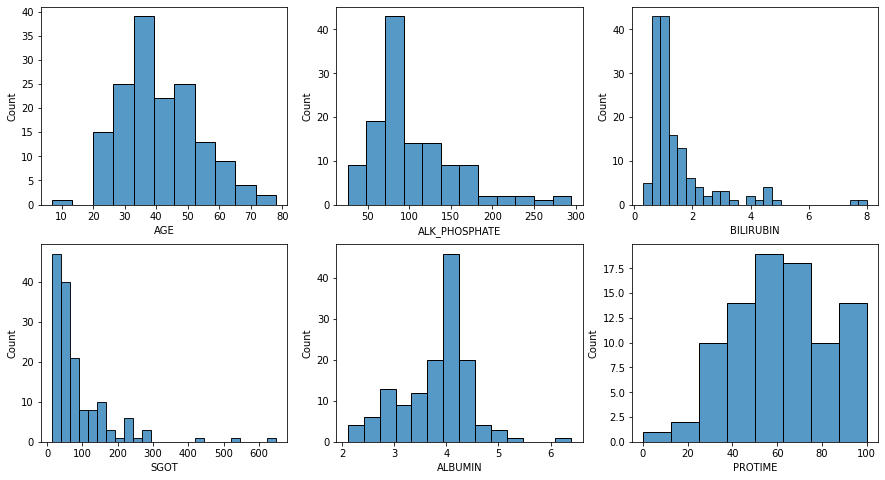

In [4]:
_, matrix = plt.subplots(2, 3, figsize=(15, 8))

sns.histplot(df.AGE, ax=matrix[0][0])
sns.histplot(df.BILIRUBIN, ax=matrix[0][2])
sns.histplot(df.ALK_PHOSPHATE, ax=matrix[0][1])
sns.histplot(df.SGOT, ax=matrix[1][0])
sns.histplot(df.ALBUMIN, ax=matrix[1][1])
sns.histplot(df.PROTIME, ax=matrix[1][2])

plt.show()

A partir desses gráficos podemos observar que a maioria dos dados têm, de fato, uma distribuição aproximadamente normal. É visualmente claro que não é perfeito, mas isso se dá à natureza dos dados, e não da presença de viés.

Por exemplo: o normal para o teste SGOT é obter um número baixo, entre 8 e 45. Quanto mais baixo, melhor, mas danos em órgãos que contêm enzimas podem causar um resultado numérico maior. É exatamente por isso que os dados têm uma aparência de curva descendente, quanto mais alto, mais raro (e mais preocupante, medicamente falando).

Esse padrão também segue no teste BILIRUBIN, que possui mais ou menos a mesma aparência.

## Pré-processamento dos dados

O problema que temos que resolver agora é que existem muitos registros sem dados. Ou seja, muitas informações faltando. É possível simplesmente ignorar isso em alguns modelos de machine learning, pois eles sabem lidar com isso internamente. Porém, os modelos da sklearn não estão nesse conjunto.

In [5]:
na_series = df.isna().sum(axis=1)
na_qtd = (na_series > 0).sum()
print(f"Existem {na_qtd} linhas com dados faltando")

Existem 75 linhas com dados faltando


<!-- Como estamos usando a biblioteca sklearn, precisamos substituir todos os dados faltando por algum dado numérico. Originalmente esses dados eram "?", mas foram substituídos por NaN para a análise de dados. Agora, precisamos colocar um valor numérico válido. -->

O jeito mais prático de lidar com os registros em branco é apagar eles do banco de dados, mas temos pouquíssimos dados pra trabalhar, então perderemos informação demais. Precisamos encontrar um caminho melhor.

<!-- Existem vários jeitos de substituir esse valor, e o mais simples deles é simplesmente substituir pela média do respectivo valor no dataset. Usaremos essa estratégia. -->
Existem vários jeitos de substituir esse valor, como substituir pela média ou pela moda da coluna em questão. Usaremos a média para as variáveis intervalares, e a moda para as variáveis categóricas.

In [6]:
from sklearn.impute import SimpleImputer

# substituicao da categorico por moda
categorical_columns = ["SEX", "STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE", "ANOREXIA", "LIVER_BIG", "LIVER_FIRM", "SPLEEN_PALPABLE", "SPIDERS", "ASCITES", "VARICES", "HISTOLOGY"]
df_cat = df[categorical_columns]

imp_frequent = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df_cat = pd.DataFrame(imp_frequent.fit_transform(df_cat))

df_cat.columns = categorical_columns
df[categorical_columns] = df_cat

# substituicao da intervalar por media
interval_columns = ["AGE", "BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME"]
df_int = df[interval_columns]

imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
df_int = pd.DataFrame(imp_mean.fit_transform(df_int))

df_int.columns = interval_columns
df[interval_columns] = df_int

df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,23.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,105.325397,85.89404,3.817266,61.852273,1.0,2
1,43.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.2,100.000000,19.00000,3.100000,42.000000,2.0,1
2,48.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,4.8,123.000000,157.00000,2.700000,31.000000,2.0,1
3,34.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.8,127.000000,182.00000,3.817266,61.852273,1.0,1
4,36.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,0.8,85.000000,44.00000,4.200000,85.000000,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,54.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.9,120.000000,28.00000,3.500000,43.000000,2.0,1
151,47.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,84.000000,23.00000,4.200000,66.000000,2.0,1
152,36.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.1,141.000000,75.00000,3.300000,61.852273,2.0,2
153,25.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.4,45.000000,18.00000,4.300000,70.000000,1.0,2


Também precisamos fazer a separação entre dataset de treino e dataset de teste.

In [7]:
df_train = df.sample(frac=0.9, random_state=random_state)
df_test = df.drop(df_train.index)

x_train = df_train.drop(columns="CLASS")
y_train = df_train.CLASS

x_test = df_test.drop(columns="CLASS")
y_test = df_test.CLASS

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((140, 19), (140,), (15, 19), (15,))

## Modelos de Machine Learning

A função `eval_model` será a função principal para avaliar cada um dos três modelos que trabalharemos aqui: uma árvore de decisão e duas florestas randômicas.

Ela recebe um modelo e gera a previsão, em cima do dataset de treino, através da validação cruzada. Com essa predição, geraremos a matriz de confusão e a curva ROC, com a pontuação AUC

Usaremos a pontuação AUC para decidir qual será o melhor modelo e, uma vez decidido, iremos fazer uma análise mais profunda sobre o modelo vencedor, usando tanto o dataset de treino quanto o de teste.

In [8]:
def generate_confusion_matrix(y_true, y_pred, ax):
  """Função que gera gráfico de matriz de confusão

  Args:
      y_true (DataFrame): labels verdadeiras dos dados
      y_pred (DataFrame): labels previstas dos dados

  Returns:
      Objeto de gráfico pyplot
  """
  conf_mat = confusion_matrix(y_true, y_pred)
  return sns.heatmap(conf_mat, annot=True, xticklabels=["actual dead", "actual alive"], yticklabels=["pred dead", "pred alive"], ax=ax)

def generate_roc_auc_curve(y_true, y_pred, ax):
  """Função que gera gráfico de curva roc_auc

  Args:
      y_true (DataFrame): labels verdadeiras dos dados
      y_pred (DataFrame): labels previstas dos dados

  Returns:
      Objeto de gráfico pyplot
  """
  fp, tp, _ = roc_curve(y_true, y_pred, pos_label=2)
  return metrics.RocCurveDisplay(fpr = fp, tpr = tp, pos_label=2).from_predictions(y_true, y_pred, pos_label=2, ax=ax)

def eval_model(model, x_train, y_train):
  """Função que avalia determinado modelo de machine learning, gerando gráficos através da validação cruzada

  Args:
      model: sklearn machine learning model
      x_train (DataFrame): dados do conjunto de treinamento
      y_train (DataFrame): labels do conjunto de treinamento
  """
  _, axs = plt.subplots(1, 2, figsize=(12, 4))
  y_pred = cross_val_predict(model, x_train, y_train, cv=10)
  generate_confusion_matrix(y_train, y_pred, axs[0])
  generate_roc_auc_curve(y_train, y_pred, axs[1])

### Árvore de Decisão

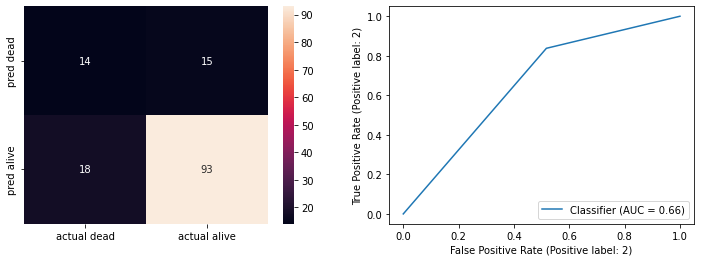

In [9]:
from sklearn import tree

model_dt = tree.DecisionTreeClassifier(criterion="entropy", max_features=19, random_state=random_state)

eval_model(model_dt, x_train, y_train)

### Floresta Randômica (19 preditores)

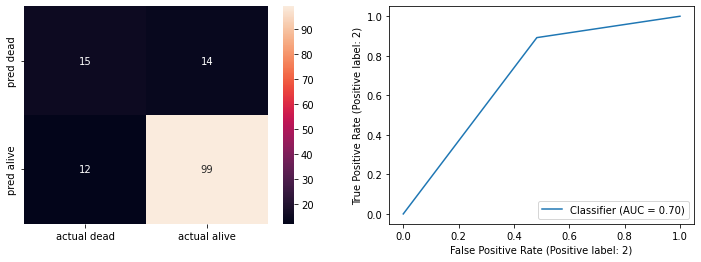

In [10]:
from sklearn.ensemble import RandomForestClassifier

model_rf19 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_features=19, random_state=random_state)

eval_model(model_rf19, x_train, y_train)

### Floresta Randômica (4 preditores)

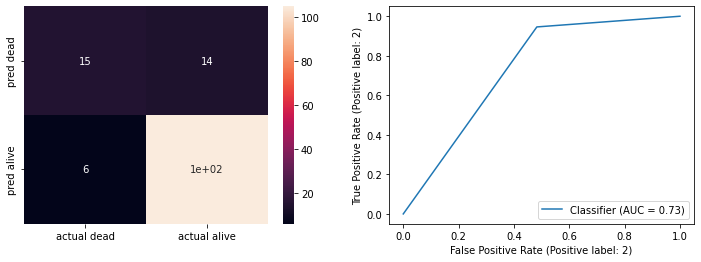

In [11]:
model_rf4 = RandomForestClassifier(n_estimators=100, criterion="entropy", max_features=4, random_state=random_state)

eval_model(model_rf4, x_train, y_train)

## Análise de Resultados

O melhor modelo que obtivemos foi a floresta randômica de 4 variáveis preditoras, de acordo com a pontuação AUC. Mas ela é superior à floresta de 19 variáveis por uma margem tão pequena que, com uma mudança no `random_state`, podemos encontrar um resultado diferente. Independentemente, declararemos ela a vencedora.

Vamos resgatar aquele modelo e treiná-lo com o dataset de treino inteiro, dessa vez:

In [12]:
model_rf4.fit(x_train, y_train)
y_predict = model_rf4.predict(x_test)

print(f"Accuracy: {metrics.accuracy_score(y_test, y_predict)}")
print(f"Precision: {metrics.precision_score(y_test, y_predict)}")
print(f"Recall: {metrics.recall_score(y_test, y_predict)}")
print(f"F1: {metrics.f1_score(y_test, y_predict)}")

Accuracy: 0.8666666666666667
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666


Podemos ver, através da alta na acurácia, mas relativa baixa precisão, que o modelo é muito melhor em classificar negativos (vivos) que positivos (mortos). Isso é um reflexo claro do desbalanceamento do dataset: existem muito mais pessoas vivas que mortas representadas no dataset. Podemos, também, obter a taxa de acerto para previsões de vivos no dataset:

In [13]:
_, _, falso_morto, verdadeiro_vivo = confusion_matrix(y_test, y_predict).flatten()
specificity = verdadeiro_vivo / (verdadeiro_vivo+falso_morto)
specificity

0.9166666666666666

Também é de muito interesse ver quais são as features mais importantes do dataset, ou seja, as que mais influenciam na classificação:

In [14]:
feature_importance = pd.Series(model_rf4.feature_importances_)
feature_importance.name = "Feature Importance"
feature_importance.index = x_train.columns
feature_importance.sort_values(ascending=False)

ALBUMIN            0.165981
BILIRUBIN          0.146815
PROTIME            0.103909
ALK_PHOSPHATE      0.089107
AGE                0.086738
SGOT               0.072021
ASCITES            0.059188
SPIDERS            0.052014
FATIGUE            0.030699
HISTOLOGY          0.030282
VARICES            0.028822
MALAISE            0.026512
SPLEEN_PALPABLE    0.024207
STEROID            0.020183
LIVER_FIRM         0.018135
LIVER_BIG          0.016033
ANOREXIA           0.015235
SEX                0.010013
ANTIVIRALS         0.004106
Name: Feature Importance, dtype: float64

Ordenados por ordem de importância, vemos que os níveis da Albumina e o teste de Bilirrubina são os mais relevantes na classificação, enquanto as variáveis de sexo e anti-virais, pouco importam. É possível, inclusive, que elas realmente não influenciam em nada, mas por uma coincidência, elas trouxeram algum nível de segregação de classes no modelo. Apenas um especialista ou mais dados podem confirmar essa hipótese